In [1]:
import bokeh, bokeh.plotting, bokeh.models
from bokeh.io import output_notebook, show
import sklearn.preprocessing
from shapely.geometry import Point
import urllib
output_notebook()

from time import time
import geopandas as gpd
import dask.dataframe as dd
import dask.distributed
import numpy as np
import pandas as pd
from datetime import datetime
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from os import listdir
from os.path import isfile, join


client = dask.distributed.Client()

Loading BokehJS ...

In [2]:
def assign_taxi_zones(df, lon_var, lat_var, locid_var):
    """Joins DataFrame with Taxi Zones shapefile.
    This function takes longitude values provided by `lon_var`, and latitude
    values provided by `lat_var` in DataFrame `df`, and performs a spatial join
    with the NYC taxi_zones shapefile. 
    The shapefile is hard coded in, as this function makes a hard assumption of
    latitude and longitude coordinates. It also assumes latitude=0 and 
    longitude=0 is not a datapoint that can exist in your dataset. Which is 
    reasonable for a dataset of New York, but bad for a global dataset.
    Only rows where `df.lon_var`, `df.lat_var` are reasonably near New York,
    and `df.locid_var` is set to np.nan are updated. 
    Parameters
    ----------
    df : pandas.DataFrame or dask.DataFrame
        DataFrame containing latitudes, longitudes, and location_id columns.
    lon_var : string
        Name of column in `df` containing longitude values. Invalid values 
        should be np.nan.
    lat_var : string
        Name of column in `df` containing latitude values. Invalid values 
        should be np.nan
    locid_var : string
        Name of series to return. 
    """

    import geopandas
    from shapely.geometry import Point


    # make a copy since we will modify lats and lons
    localdf = df[[lon_var, lat_var]].copy()
    
    # missing lat lon info is indicated by nan. Fill with zero
    # which is outside New York shapefile. 
    localdf[lon_var] = localdf[lon_var].fillna(value=0.)
    localdf[lat_var] = localdf[lat_var].fillna(value=0.)
    

    shape_df = geopandas.read_file('/home/surajravi/taxi_project/taxi_zones/taxi_zones.shp')
    shape_df.drop(['OBJECTID', "Shape_Area", "Shape_Leng", "borough", "zone"],
                  axis=1, inplace=True)
    shape_df = shape_df.to_crs({'init': 'epsg:4326'})

    try:
        local_gdf = geopandas.GeoDataFrame(
            localdf, crs={'init': 'epsg:4326'},
            geometry=[Point(xy) for xy in
                      zip(localdf[lon_var], localdf[lat_var])])

        local_gdf = geopandas.sjoin(
            local_gdf, shape_df, how='left', op='within')

        return local_gdf.LocationID.rename(locid_var)
    except ValueError as ve:
        print(ve)
        print(ve.stacktrace())
        series = localdf[lon_var]
        series = np.nan
        return series

In [3]:
def pickup_time(df,locid_var):
    return pd.to_datetime(df['tpep_pickup_datetime'].str[:-6],infer_datetime_format=True).rename(locid_var)

In [4]:
def collect_data(file):
    trips = dd.read_csv(file)
    trips['pickup_taxizone_id'] = trips.map_partitions(
    assign_taxi_zones, "pickup_longitude", "pickup_latitude",
    "pickup_taxizone_id", meta=('pickup_taxizone_id', np.float64))

    trips['pickup_datetime'] = trips.map_partitions(
    pickup_time, 'pickup_datetime', meta=('pickup_datetime', np.datetime64))
    
    t0 = time()
    counts = trips.groupby(['pickup_datetime', 'pickup_taxizone_id']).count().compute()
    print(file)
    print('counts', (time()-t0)/60, 'minutes')

    t0 = time()
    sum_fares = trips.groupby(['pickup_datetime', 'pickup_taxizone_id']).sum().compute()
    print('fares', (time()-t0)/60, 'minutes')
    
    counts = counts.reset_index()
    sum_fares = sum_fares.reset_index()
    counts = counts[['pickup_datetime', 'pickup_taxizone_id', 'total_amount']]
    sum_fares = sum_fares[['pickup_datetime', 'pickup_taxizone_id', 'total_amount']]
    counts = counts.rename(columns={'total_amount':'rides'})
    sum_fares = sum_fares.rename(columns={'total_amount':'sum_fares'})
    init_df = pd.merge(counts, sum_fares, how='left', left_on=['pickup_datetime','pickup_taxizone_id'],\
             right_on=['pickup_datetime','pickup_taxizone_id'])
    init_df = init_df[['pickup_datetime', 'pickup_taxizone_id', 'rides', 'sum_fares']]
    client.cancel(trips)
    return init_df

In [5]:
path = 'taxi_project/data/2015_2016/'
files = [path+f for f in listdir(path) if isfile(join(path, f))]

In [11]:
df = collect_data(files[0])

for file in files[1:]:
    df_curr = collect_data(file)
    df = df.append(df_curr)
    df = df.reset_index()
    df = df[['pickup_datetime', 'pickup_taxizone_id', 'rides', 'sum_fares']]

df.head()

pickup_datetime  pickup_taxizone_id  rides  sum_fares
0      2016-04-01                 4.0     74    1285.21
1      2016-04-01                 7.0     43     624.03
2      2016-04-01                10.0      1      58.34
3      2016-04-01                12.0      2      46.05
4      2016-04-01                13.0     52     934.69

In [12]:
df = pickle.load(open('pickles/2015_2016_taxis.pkl', 'rb'))
grouped = pickle.load(open('pickles/grouped.pkl', 'rb'))

## Read in Taxi Zones

In [13]:
taxi_zone_key = pd.read_csv('taxi_project/taxi+_zone_lookup.csv')

In [14]:
neighbs = taxi_zone_key[['LocationID','Zone']].to_dict()
neighb_key = {neighbs['LocationID'][m]: neighbs['Zone'][m] for m in neighbs['LocationID'].keys()}
b = taxi_zone_key[['LocationID','Borough','Zone']].to_dict()
b_key = {b['LocationID'][m]:b['Borough'][m] for m in b['LocationID'].keys()}

In [16]:
t0 = time()
df['borough'] = df.apply(lambda row: b_key[row['pickup_taxizone_id']], axis= 1)
print('counts', (time()-t0)/60, 'minutes')

counts 1.840618371963501 minutes


In [17]:
grouped = df.groupby(['borough']).sum()
grouped = grouped.reset_index()

In [18]:
coord_system = {'init': 'epsg:3395'}##Using this encoding in order to calculate area in km^2
gdf = gpd.read_file('/home/surajravi/taxi_project/taxi_zones/taxi_zones.shp').to_crs(coord_system)
gdf = gdf.drop(['Shape_Area', 'Shape_Leng', 'OBJECTID'], axis=1)
gdf['area'] = gdf['geometry'].area/10**6
gdf.head()

zone  LocationID        borough  \
0           Newark Airport           1            EWR   
1              Jamaica Bay           2         Queens   
2  Allerton/Pelham Gardens           3          Bronx   
3            Alphabet City           4      Manhattan   
4            Arden Heights           5  Staten Island   

                                            geometry       area  
0  POLYGON ((-8258175.532737532 4939590.488999957...  12.736223  
1  (POLYGON ((-8217980.621910957 4931402.32096114...  23.137078  
2  POLYGON ((-8220713.534155379 4965416.648662397...   5.132194  
3  POLYGON ((-8234500.226961649 4944099.916942869...   1.294162  
4  POLYGON ((-8257036.10884249 4920241.492315316,...   8.089915

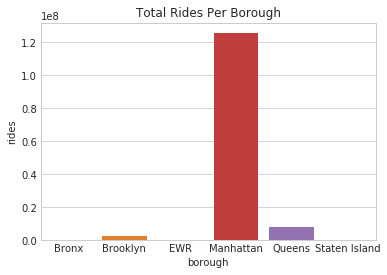

In [19]:
## Totals only include yellow cabs
sns.set_style("whitegrid")
ax = sns.barplot(x="borough", y="rides", data=grouped)
ax.set_title('Total Rides Per Borough')
plt.savefig('borough_hist.pdf')

In [20]:
zones = df.groupby(['pickup_taxizone_id']).sum().reset_index()
zones = pd.merge(zones,gdf[['LocationID','area']], left_on="pickup_taxizone_id",right_on="LocationID" )
zones=zones.drop(['LocationID'],axis=1)
zones['neighb'] = zones.apply(lambda row: neighb_key[row['pickup_taxizone_id']],axis=1)
zones['rides_psqkm'] = zones.apply(lambda row: row['rides']/row['area'], axis=1)
zones['fares_psqkm'] = zones.apply(lambda row: row['sum_fares']/row['area'], axis=1)

In [21]:
zones.head()

pickup_taxizone_id   rides   sum_fares       area                   neighb  \
0                  1    8914   737702.93  12.736223           Newark Airport   
1                  2      60     2110.01  23.137078              Jamaica Bay   
2                  3     599    11654.62   5.132194  Allerton/Pelham Gardens   
3                  4  435107  6635579.90   1.294162            Alphabet City   
4                  5      46     3368.84   8.089915            Arden Heights   

     rides_psqkm   fares_psqkm  
0     699.893544  5.792164e+04  
1       2.593240  9.119605e+01  
2     116.714218  2.270885e+03  
3  336207.502699  5.127318e+06  
4       5.686092  4.164247e+02

In [22]:
with open('pickles/gdf.pkl', 'wb') as f:
    pickle.dump(gdf, f)

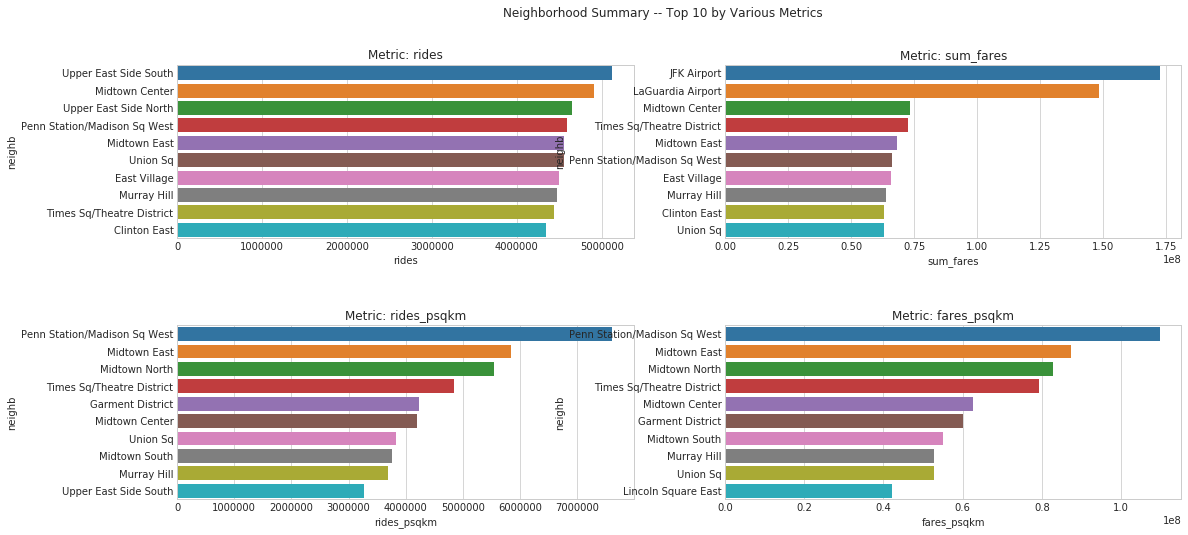

In [23]:
##View Top 10 neighbs for various metrics

columns = ['rides', 'sum_fares','rides_psqkm','fares_psqkm']
fig, axarr = plt.subplots(2, 2,figsize=(18,8))
fig.subplots_adjust(hspace=.5)
fig.suptitle('Neighborhood Summary -- Top 10 by Various Metrics')

i = 0
j = 0
for column in columns:
    df_curr = zones.sort_values([column],ascending=False).head(10)[[column, 'neighb']]
    sns.barplot(x=column, y = 'neighb', data = df_curr, ax =axarr[i,j])    
    axarr[i,j].set_title('Metric: %s' % column)
    j += 1
    if j == 2:
        j = 0
        i += 1


In [28]:
##Visualize ride density by neighb throughout all of NYC

# <!-- collapse=True -->
column = 'fares_psqkm'
curr_param = zones[['pickup_taxizone_id',column]]
curr = pd.merge(gdf, curr_param, left_on = 'LocationID', right_on = 'pickup_taxizone_id')

gjds = bokeh.models.GeoJSONDataSource(geojson=curr.to_json())
TOOLS = "pan,wheel_zoom,reset,hover,save"

p = bokeh.plotting.figure(title="NYC Taxi Pickups Heatmap: %s"%column, tools=TOOLS,
    x_axis_location=None, y_axis_location=None, 
    responsive=True)

color_mapper = bokeh.models.LogColorMapper(palette=bokeh.palettes.RdYlBu10, low=100000, high=7600000)

p.patches('xs', 'ys', 
          fill_color={'field': column, 'transform': color_mapper},
          fill_alpha=1., line_color="black", line_width=0.5,          
          source=gjds)

p.grid.grid_line_color = None

hover = p.select_one(bokeh.models.HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = u"""
<div> 
    <div class="bokeh_hover_tooltip">Name : @zone</div>
    <div class="bokeh_hover_tooltip">Borough : @borough</div>
    <div class="bokeh_hover_tooltip">Trips Start : @fares_psqkm</div>
</div>
"""

color_bar = bokeh.models.ColorBar(
    color_mapper=color_mapper, orientation='horizontal',
    ticker=bokeh.models.FixedTicker(ticks=[10**m for m in range(10)]),
    formatter=bokeh.models.PrintfTickFormatter(format='%d'),
    label_standoff=12, border_line_color=None, location=(0,0))
p.add_layout(color_bar, 'below')

show(p)

In [24]:
##Visualize total rides by neighb throughout Manhattan

# <!-- collapse=True -->
column = 'rides'
curr_param = zones[['pickup_taxizone_id',column]]
curr = pd.merge(gdf, curr_param, left_on = 'LocationID', right_on = 'pickup_taxizone_id')

gjds = bokeh.models.GeoJSONDataSource(geojson=curr[curr['borough']=='Manhattan'].to_json())
TOOLS = "pan,wheel_zoom,reset,hover,save"

p = bokeh.plotting.figure(title="NYC Taxi Pickups Heatmap: %s"%column, tools=TOOLS,
    x_axis_location=None, y_axis_location=None, 
    responsive=True)

color_mapper = bokeh.models.LogColorMapper(palette=bokeh.palettes.RdYlBu10, low=1250000, high=5000000)

p.patches('xs', 'ys', 
          fill_color={'field': column, 'transform': color_mapper},
          fill_alpha=1., line_color="black", line_width=0.5,          
          source=gjds)

p.grid.grid_line_color = None

hover = p.select_one(bokeh.models.HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = u"""
<div> 
    <div class="bokeh_hover_tooltip">Name : @zone</div>
    <div class="bokeh_hover_tooltip">Borough : @borough</div>
    <div class="bokeh_hover_tooltip">Trips Start : @rides</div>
</div>
"""

color_bar = bokeh.models.ColorBar(
    color_mapper=color_mapper, orientation='horizontal',
    ticker=bokeh.models.FixedTicker(ticks=[m for m in range(10)]),
    formatter=bokeh.models.PrintfTickFormatter(format='%d'),
    label_standoff=12, border_line_color=None, location=(0,0))
p.add_layout(color_bar, 'below')

show(p)

In [33]:
curr[curr['borough']=='Manhattan'].fares_psqkm.describe()

count    7.500000e+01
mean     2.245967e+07
std      2.386679e+07
min      5.109096e+02
25%      1.023881e+06
50%      1.921559e+07
75%      3.440387e+07
max      1.097134e+08
Name: fares_psqkm, dtype: float64

In [40]:
# <!-- collapse=True -->
column = 'rides_psqkm'
curr_param = zones[['pickup_taxizone_id',column]]
curr = pd.merge(gdf, curr_param, left_on = 'LocationID', right_on = 'pickup_taxizone_id')

gjds = bokeh.models.GeoJSONDataSource(geojson=curr[curr['borough']=='Manhattan'].to_json())
TOOLS = "pan,wheel_zoom,reset,hover,save"

p = bokeh.plotting.figure(title="NYC Taxi Pickups Heatmap: %s"%column, tools=TOOLS,
    x_axis_location=None, y_axis_location=None, 
    responsive=True)

color_mapper = bokeh.models.LogColorMapper(palette=bokeh.palettes.RdYlBu10, low=1000000, high=10100000)

p.patches('xs', 'ys', 
          fill_color={'field': column, 'transform': color_mapper},
          fill_alpha=1., line_color="black", line_width=0.5,          
          source=gjds)

p.grid.grid_line_color = None

hover = p.select_one(bokeh.models.HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = u"""
<div> 
    <div class="bokeh_hover_tooltip">Name : @zone</div>
    <div class="bokeh_hover_tooltip">Borough : @borough</div>
    <div class="bokeh_hover_tooltip">Trips Start : @rides_psqkm</div>
</div>
"""

color_bar = bokeh.models.ColorBar(
    color_mapper=color_mapper, orientation='horizontal',
    ticker=bokeh.models.FixedTicker(ticks=[m*100000 for m in range(10)]),
    formatter=bokeh.models.PrintfTickFormatter(format='%d'),
    label_standoff=12, border_line_color=None, location=(0,0))
p.add_layout(color_bar, 'below')

show(p)